In [5]:
cd /Users/sandra/work/Bioinformatics/Soybeans

/Users/sandra/work/Bioinformatics/Soybeans


In [10]:
pwd

'/Users/sandra/work/Bioinformatics/Soybeans'

In [11]:
with open('Forrest B100B10 BAC sequence Rhg4.txt', 'r') as forrest_file:
    forrest_seq = forrest_file.read()

forrest_seq[:100]

'> [Glycine max] Forrest B100B10 BAC sequence, Rhg4 \nCCCTCGCGAGTTGGTTCAGCTGCTGCCTGAGGCTGGACGACCTCGCGG'

In [2]:
with open('Forrest B100B10 BAC sequence Rhg4.txt', 'r') as forrest_file:
    forrest_lines = ''
    file_line = forrest_file.readline().rstrip()
    # forrest_lines += file_line

    while file_line:
        forrest_lines += file_line
        file_line = forrest_file.readline().rstrip()

forrest_lines[:300]


'> [Glycine max] Forrest B100B10 BAC sequence, Rhg4CCCTCGCGAGTTGGTTCAGCTGCTGCCTGAGGCTGGACGACCTCGCGGAGTTCTACCGGCAGTGCAAATCCGTCGGCATCCAGGAAACCAGCAGCGGCTATCCGCGCATCCATGCCCCCGAACTGCAGGAGTGGGGAGGCACGATGGCCGCTTTGGTCGACCTGCAGGGGGGGGGGGCGCTGAGGTCTGCCTCGTGAAGAAGGTGTTGCTGACTCATACCAGGCCTGAATCGCCCCATCATCCAGCCAGA'

#### The file containing the Forrest sequence I am working with starts with the FASTA format header. This header doesn't help much in downstreadm analysis, so I need to find index where actual sequence starts.

In [13]:
forrest_lines.find('Rhg4')

46

In [14]:
forrest_lines[46]

'R'

In [15]:
forrest_lines[46:50]

'Rhg4'

Since Python starts index at 0, Rhg4 (name of the region/locus) is indices 46-49. Actual Forrest sequence starts at index 50.

In [16]:
forrest_lines[50:55]

'CCCTC'

#### I am proceeding to searching for presence of genes in the ranges of alignment. I am starting with the ranges of alignment for the soybean cultivar Williams chromosomes 8 and 5, since when running Nucleotide BLAST, they gave the highest total score and E value. Using the Forrest Rhg4 sequence, I am adjusting the boundaries given by BLAST for the FASTA format header.

#### When I performed the alignment using Nucleotide BLAST, the first range of alignment was 1036 through 40810 in my input Forrest sequence. Adjusting for the way Python does indexing, this interval becomes 1036-40811 (we want Python to go through base 40810). Length of FASTA format header is 50.

In [17]:
start_codon = 'ATG'
sequence = forrest_lines[1036+50:40811]
sequence.find(start_codon)


58

In [24]:
stop_codons = ['TAA', 'TAG', 'TGA']
sequence = forrest_lines[1036+50:40811]

stop_codon_indices = []
for codon in stop_codons:
    index = sequence.find(codon)
    stop_codon_indices.append(index)

print(f'indices of stop codons in the 1037-40810 range of alignment: {stop_codon_indices}')

indices of stop codons in the 1037-40810 range of alignment: [16, 6, 59]


In [25]:
# trying to reverse the stop codons

stop_codon_indices = []
for codon in stop_codons:
    index = sequence.find(codon[::-1])
    stop_codon_indices.append(index)

stop_codon = sequence[263:266][::-1]
print(f'stop indices reversed: {stop_codon_indices}')
print(f'stop codon: {stop_codon}')

print(sequence[263:266])

stop indices reversed: [57, 98, 266]
stop codon: CAA
AAC


In [26]:
# loop over the sequence when looking for start codon

start_codon = 'ATG'
start_codon_indices = []
sequence = forrest_lines[1036+50:40811]

index = sequence.find(start_codon)
while index >= 0:
    start_codon_indices.append(index)
    index = sequence.find(start_codon, index+len(start_codon))

print(f'number of possible start codons: {len(start_codon_indices)}')
print(f'first 10 indices of start codon: {start_codon_indices[:10]}')


number of possible start codons: 733
first 10 indices of start codon: [58, 146, 211, 306, 381, 522, 689, 1011, 1074, 1090]


In [3]:
# finding TATA boxes
tata_box = 'TATAAA'
sequence = forrest_lines[1036+50:40811]
tata_indices = []

index = sequence.find(tata_box)
while index >= 0:
    tata_indices.append(index)
    index = sequence.find(tata_box, index + len(tata_box))

print(f'number of TATA boxes: {len(tata_indices)}')
print(f'first 10 indices of TATA boxes: {tata_indices[:10]}')

number of TATA boxes: 51
first 10 indices of TATA boxes: [204, 376, 432, 1998, 2031, 3615, 3944, 4539, 5088, 5185]


Since TATA boxes are 25-35 base pairs upstream of the transcription start site in most eukaryotic genes, we can rule out codons at indices 58, 146, 211 as start codons and presence of genes. Starting gene search from index 1419 (start of sequence + index of TATA box + length of the TATA box + 25 bp downstream of the TATA box)

In [4]:
# start codons starting from 25 bp downstream of the TATA box
codon = 'ATG'
sequence = forrest_lines[1419:40811]

poss_start_codons = []
index = sequence.find(codon)
while index >= 0:
    poss_start_codons.append(index)
    index = sequence.find(codon, index + len(codon))

print(f'number of possible start codons: {len(poss_start_codons)}')

number of possible start codons: 729


In [29]:
# stop codons starting from 35 bp downstream of the TATA box (TATA box 25-35 bp upstream of the gene)
stop_codons = ['TAA', 'TAG', 'TGA']
sequence = forrest_lines[1419+10:40811]

poss_stop_codons = []
for codon in stop_codons:
    index = sequence.find(codon)
    while index >= 0:
        poss_stop_codons.append(index)
        index = sequence.find(codon, index + len(codon))

print(f'number of possible stop codons: {len(poss_stop_codons)}')

number of possible stop codons: 2528


We got possibile start and stop codons. Let's calculate the difference between indices for each pair to get a sense of presence of genes.

In [30]:
print(f'possible start codons[:10]: {poss_start_codons[:10]}')
print(f'possible stop codons[:10]: {poss_stop_codons[:10]}')

possible start codons[:10]: [48, 189, 356, 678, 741, 757, 834, 885, 933, 1014]
possible stop codons[:10]: [10, 27, 35, 65, 91, 102, 171, 177, 262, 423]


In [31]:
# iterating through the list of possible start codons
poss_genes = []
for start in poss_start_codons:
    for stop in poss_stop_codons:
        if stop > start:
            length = stop - start
            # print(f'stop codon - start codon: {length}')
            poss_genes.append(length)

# expecting to have 729 possible genes (same as number of possible start codons), but check
print(f'number of possible genes: {len(poss_genes)}')

number of possible genes: 899469


The number of possible I got is greater than expected (there shouldn't be more genes than start codons). 

### Changing how I'm searching for gene presence. Using dictionary instead.

In [32]:
print(f'possible start codons: {poss_start_codons}')

possible start codons: [48, 189, 356, 678, 741, 757, 834, 885, 933, 1014, 1017, 1164, 1200, 1245, 1278, 1320, 1328, 1386, 1399, 1403, 1407, 1476, 1484, 1494, 1840, 1908, 1975, 2017, 2059, 2071, 2145, 2167, 2216, 2230, 2240, 2249, 2414, 2485, 2508, 2629, 2636, 2649, 2798, 2838, 2870, 2924, 2959, 2982, 2991, 3004, 3148, 3156, 3252, 3349, 3409, 3437, 3445, 3578, 3607, 3616, 3621, 3682, 3761, 3768, 3834, 3845, 3877, 3887, 4133, 4167, 4246, 4302, 4306, 4317, 4331, 4383, 4402, 4406, 4460, 4466, 4472, 4593, 4597, 4603, 4608, 4703, 4737, 4814, 4963, 5119, 5136, 5145, 5160, 5182, 5200, 5208, 5224, 5282, 5294, 5382, 5500, 5544, 5628, 5704, 5747, 5775, 5779, 5808, 5850, 5970, 5996, 5999, 6381, 6532, 6579, 6602, 6606, 6628, 6698, 6711, 6827, 6834, 6839, 6858, 6902, 7003, 7028, 7059, 7064, 7114, 7127, 7145, 7257, 7279, 7286, 7313, 7391, 7447, 7478, 7482, 7529, 7583, 7628, 7646, 7696, 7707, 7719, 7758, 7769, 7774, 7790, 7878, 7897, 7914, 7924, 8036, 8056, 8144, 8349, 8389, 8434, 8437, 8499, 8506, 85

In [33]:
poss_genes_dict = {}
for start in poss_start_codons:
    for stop in poss_stop_codons:
        if stop > start:
            poss_gene_len = stop - start
            poss_genes_dict[poss_gene_len] = (start, stop)

print(f'number of possible genes: {len(poss_genes_dict)}')
print(f'first 5 possible genes: {poss_genes_dict}')

number of possible genes: 38216
first 5 possible genes: {17: (39301, 39318), 43: (39244, 39287), 54: (39301, 39355), 123: (37961, 38084), 129: (36995, 37124), 214: (38867, 39081), 375: (38860, 39235), 396: (37376, 37772), 492: (38098, 38590), 512: (38741, 39253), 563: (38027, 38590), 854: (38098, 38952), 872: (37920, 38792), 1449: (37726, 39175), 1519: (35857, 37376), 1600: (37361, 38961), 1609: (37394, 39003), 1617: (37579, 39196), 1624: (37462, 39086), 1642: (37616, 39258), 1661: (37699, 39360), 1686: (37400, 39086), 1691: (37133, 38824), 1703: (37652, 39355), 1706: (37118, 38824), 1720: (37361, 39081), 1737: (36731, 38468), 1740: (37462, 39202), 1756: (37361, 39117), 1771: (36746, 38517), 1817: (37501, 39318), 1820: (37376, 39196), 1823: (37373, 39196), 1826: (37400, 39226), 1829: (37373, 39202), 1847: (37316, 39163), 1906: (35992, 37898), 1942: (37400, 39342), 1957: (37385, 39342), 1971: (37376, 39347), 1987: (37373, 39360), 2019: (37156, 39175), 2026: (37316, 39342), 2106: (36564,

In [35]:
# different approach: use while loop or change for loop

poss_genes_dict = {}
i_start = 0
i_stop = 0
while i_start < len(poss_start_codons):
    if i_stop >= i_start:
        length = poss_stop_codons[i_stop] - poss_start_codons[i_start]
        poss_genes_dict[length] = (poss_start_codons[i_start], poss_stop_codons[i_stop])
        i_start += 1
        i_stop += 1
    else:
        i_stop += 1

print(f'possible genes: {len(poss_genes_dict)}')

possible genes: 686


### We have a reasonable number of possible genes in this region of the Forrest sequence. It is likely that the other 30 possible start codons are located such that their indices are bigger than the indices of the corresponding possible stop codons. Putting this into a function.

In [36]:
def get_possible_genes(poss_start_codons, poss_stop_codons):
    """Function takes list of possible start codons and list of possible stop codons.
    It returns dictionary with the number of possible genes, where keys are the length of each possible gene
    and values are the start, stop indices where the gene is."""
    poss_genes_dict = {}
    i_start = 0
    i_stop = 0
    while i_start < len(poss_start_codons):
        if i_stop > i_start:
            length = poss_stop_codons[i_stop] - poss_start_codons[i_start]
            poss_genes_dict[length] = (poss_start_codons[i_start], poss_stop_codons[i_stop])
            i_start += 1
            i_stop += 1
        else:
            i_stop += 1

        return poss_genes_dict

get_possible_genes (poss_start_codons, poss_stop_codons)

{}

Troubleshooting code for finding possible genes

In [37]:
with open('Forrest B100B10 BAC sequence Rhg4.txt', 'r') as forrest_file:
    forrest_seq = ''
    file_line = forrest_file.readline().rstrip()
    # forrest_lines += file_line

    while file_line:
        forrest_seq += file_line
        file_line = forrest_file.readline().rstrip()

forrest_seq[:300]

'> [Glycine max] Forrest B100B10 BAC sequence, Rhg4CCCTCGCGAGTTGGTTCAGCTGCTGCCTGAGGCTGGACGACCTCGCGGAGTTCTACCGGCAGTGCAAATCCGTCGGCATCCAGGAAACCAGCAGCGGCTATCCGCGCATCCATGCCCCCGAACTGCAGGAGTGGGGAGGCACGATGGCCGCTTTGGTCGACCTGCAGGGGGGGGGGGCGCTGAGGTCTGCCTCGTGAAGAAGGTGTTGCTGACTCATACCAGGCCTGAATCGCCCCATCATCCAGCCAGA'

In [38]:
def get_codon_indices(codon, sequence, start_point):
    poss_indices = []
    index = sequence.find(codon, start_point)
    while index >= 0:
        poss_indices.append(index)
        index = sequence.find(codon, index+len(codon))
    
    return poss_indices

start_codon = 'ATG'
sequence = forrest_lines[:40811]
start_point = 1419
poss_start_codon_ind = get_codon_indices(start_codon, sequence, start_point)
print(f'number of possible start codons: {len(poss_start_codon_ind)}')


number of possible start codons: 729


In [39]:
stop_codons = ['TAA', 'TAG', 'TGA']
start_point = 1419

poss_stop_codon_ind = []
for codon in stop_codons:
    poss_stop_codon_ind = get_codon_indices(codon, sequence, start_point)

print(f'number of possible stop codons: {len(poss_stop_codon_ind)}')


number of possible stop codons: 833


In [40]:
print(f'indices of first 5 possible start codons: {poss_start_codon_ind[:5]}')
print(f'indices of first 5 possible stop codons: {poss_stop_codon_ind[:5]}')

indices of first 5 possible start codons: [1467, 1608, 1775, 2097, 2160]
indices of first 5 possible stop codons: [1468, 1486, 1795, 2079, 2203]


In [42]:
# let's run the get_possible_genes function again

def get_possible_genes(poss_start_codons, poss_stop_codons):
    """Function takes list of possible start codons and list of possible stop codons.
    It returns dictionary with the number of possible genes, where keys are the length of each possible gene
    and values are the start, stop indices where the gene is."""
    print(f'number of possible start codons: {len(poss_start_codons)}')
    poss_genes_dict = {}
    # i_start = 0
    i_stop = 0
    for i_start in range(len(poss_start_codons)):
        if poss_stop_codons[i_stop] > poss_start_codons[i_start]:
            print(f'if branch: poss_start_codons[i_start]:{poss_start_codons[i_start]}, poss_stop_codons[i_stop]:{poss_stop_codons[i_stop]}')
            length = poss_stop_codons[i_stop] - poss_start_codons[i_start]
            print(f'length: {length}')
            poss_genes_dict[(poss_start_codons[i_start], poss_stop_codons[i_stop])] = length
            i_start += 1
            i_stop += 1
        else:
            print(f'else branch: poss_start_codons[i_start]:{poss_start_codons[i_start]}, poss_stop_codons[i_stop]:{poss_stop_codons[i_stop]}')
            i_stop += 1

        return poss_genes_dict

poss_genes = get_possible_genes(poss_start_codon_ind, poss_stop_codon_ind)
print(f'number of possible genes: {len(poss_genes)}')
print(f'possible genes: {poss_genes}')

number of possible start codons: 729
if branch: poss_start_codons[i_start]:1467, poss_stop_codons[i_stop]:1468
length: 1
number of possible genes: 1
possible genes: {(1467, 1468): 1}


### Changing to finding indices possible stop codons using each stop codon separately

In [8]:
def find_possible_codons(codon, sequence):
    poss_codons = []
    index = sequence.find(codon)
    while index >= 0:
        poss_codons.append(index)
        index = sequence.find(codon, index + len(codon))
    return poss_codons

start_codon = 'ATG'
sequence = forrest_lines[1419:40811]
poss_start_codons = find_possible_codons(start_codon, sequence)
print(f'number of possible start codons: {len(poss_start_codons)}')

number of possible start codons: 729


In [6]:
def find_possible_codon_indices(codon, sequence):
    poss_codon_ind = []
    index = sequence.find(codon)
    while index >= 0:
        poss_codon_ind.append(index)
        index = sequence.find(codon, index + len(codon))
    return poss_codon_ind

start_codon = 'ATG'
start_point = 1419
end_point = 40811
sequence = forrest_lines[start_point:end_point]
poss_start_codon_ind = find_possible_codon_indices(start_codon, sequence)
print(f'number of possible start codons: {len(poss_start_codon_ind)}')

number of possible start codons: 729


#### When looking for indices of possible stop codons, I chose to not take mismatches like TAA to GAA into account. In addition to T (Thymine) being a because biologically speaking a lot would have to go wrong during DNA replication for such a mutation to occur. T (thymine) is a pyrimidine while G (guanine) is a purine. If in the parent DNA has T on one strand, it would have A (adenine, purine like G) on the other strand. If DNA Polymerase tried pairing G with A, this would distort the newly forming DNA molecule. Also, the structure of DNA Polymerase III is such that one of its domains (parts) corrects mistakes made during replication (like pairing C (cytosine) with A instead of T with A).

#### One of the problems with the running of get_possible_genes function resulted from putting indices for all three stop codons into one single output list. Changing to using one output list for each of the three stop codons.

In [7]:
stop_codon = 'TAA'
poss_taa_stop_codons = find_possible_codons(stop_codon, sequence)
print(f'number of possible {stop_codon} stop codons: {len(poss_taa_stop_codons)}')
stop_codon = 'TAG'
poss_tag_stop_codons = find_possible_codons(stop_codon, sequence)
print(f'number of possible {stop_codon} stop codons: {len(poss_tag_stop_codons)}')
stop_codon = 'TGA'
poss_tga_stop_codons = find_possible_codons(stop_codon, sequence)
print(f'number of possible {stop_codon} stop codons: {len(poss_tga_stop_codons)}')

number of possible TAA stop codons: 1163
number of possible TAG stop codons: 533
number of possible TGA stop codons: 833


I have the number of possible stop codon indices for each of the three stop codons. Back to finding possible genes.

In [9]:
def find_poss_genes(poss_start_codons, poss_stop_codons):
    # print(f'first 5 possible start codons: {poss_start_codons[:5]}, first 5 possible stop codons: {poss_stop_codons[:5]}')
    poss_genes = {}
    i_start = 0
    i_stop = 0

    while i_start < len(poss_start_codons) and i_stop < len(poss_stop_codons):
        if poss_stop_codons[i_stop] > poss_start_codons[i_start]:
            gene_length = poss_stop_codons[i_stop] - poss_start_codons[i_start]
            # prokaryotes have a typical gene length of 1000 base pairs and each codon is encoded by 3 bases
            if gene_length >= 1000:
                poss_genes[(poss_stop_codons[i_stop], poss_start_codons[i_start])] = gene_length
            i_start += 1
            i_stop += 1
            continue
        else:
            i_stop += 1
    
    return poss_genes

taa_genes = find_poss_genes(poss_start_codons, poss_taa_stop_codons)
print(f'number of possible genes with TAA stop codons: {len(taa_genes)}')

number of possible genes with TAA stop codons: 25


In [51]:
tag_genes = find_poss_genes(poss_start_codons, poss_tag_stop_codons)
print(f'number of possible genes with TAG stop codons: {len(tag_genes)}')

tga_genes = find_poss_genes(poss_start_codons, poss_tga_stop_codons)
print(f'number of possible genes with TGA stop codons: {len(tga_genes)}')

number of possible genes with TAG stop codons: 477
number of possible genes with TGA stop codons: 0


I have a working algorithm, but the way everything is written I need to run it for each range of alignment. It would be nice to have a way for the algorithm to run through the Forrest sequence without me having to manually move it from one range of alignment to another.

#### Plotting frequency of genes in the 1037-40810 range of alignment for TAA and TAG stop codons (this range of alignment did not have any possible genes that started at or after base pair 1419 for TGA stop codon)

In [10]:
import matplotlib.pyplot as plt

taa_genes = find_poss_genes(poss_start_codons, poss_taa_stop_codons)
print(f'possible genes with TAA as the stop codon: {taa_genes}')
tag_genes = find_poss_genes(poss_start_codons, poss_tag_stop_codons)
print(f'possible genes with TAG as the stop codon: {tag_genes}')

possible genes with TAA as the stop codon: {(31055, 30035): 1020, (31091, 30068): 1023, (38158, 37156): 1002, (38464, 37376): 1088, (38582, 37385): 1197, (38605, 37394): 1211, (38611, 37400): 1211, (38761, 37462): 1299, (38798, 37501): 1297, (38924, 37569): 1355, (38938, 37579): 1359, (38955, 37616): 1339, (38962, 37625): 1337, (38982, 37652): 1330, (38994, 37699): 1295, (39083, 37726): 1357, (39127, 37781): 1346, (39173, 37827): 1346, (39185, 37920): 1265, (39212, 37945): 1267, (39229, 37961): 1268, (39236, 37977): 1259, (39256, 37991): 1265, (39268, 37996): 1272, (39357, 38007): 1350}
possible genes with TAG as the stop codon: {(4104, 2991): 1113, (4113, 3004): 1109, (4212, 3156): 1056, (4295, 3252): 1043, (4548, 3349): 1199, (4674, 3409): 1265, (4875, 3437): 1438, (4898, 3445): 1453, (4934, 3578): 1356, (5044, 3607): 1437, (5048, 3616): 1432, (5070, 3621): 1449, (5187, 3682): 1505, (5326, 3761): 1565, (5400, 3768): 1632, (5412, 3834): 1578, (5467, 3845): 1622, (5884, 3877): 2007, (5

In [12]:
taa_gene_length = []
for index_pairs, length in taa_genes.items():
    taa_gene_length.append(length)

print(f'taa_gene_length: {len(taa_gene_length)}')
print()

tag_gene_length = []
for index_pairs, length in tag_genes.items():
    tag_gene_length.append(length)

print(f'tag_gene_length: {len(tag_gene_length)}')

taa_gene_length: 25

tag_gene_length: 477


Text(0, 0.5, 'Count')

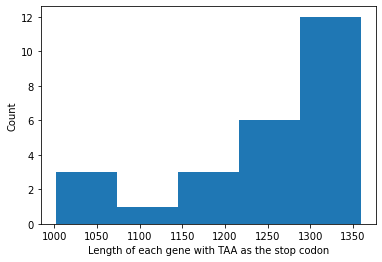

In [31]:
x_taa = taa_gene_length
taa_bins = 5
plt.hist(x_taa, bins=taa_bins)
plt.xlabel('Length of each gene with TAA as the stop codon')
plt.ylabel('Count')


We see that most possible genes are 1300-1350 bp long. This is about 10 times lower than the typical gene length in cultivated soybean genomes.

Text(0, 0.5, 'Count')

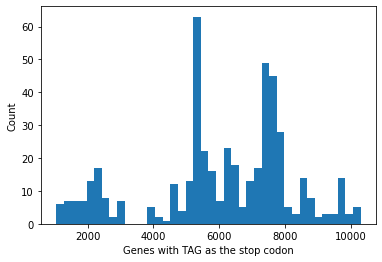

In [30]:
# repeating for TAG stop codon

x_tag = tag_gene_length
tag_bins = 40
plt.hist(x_tag, bins=tag_bins)
plt.xlabel('Genes with TAG as the stop codon')
plt.ylabel('Count')

With TAG as the stop codon, we see two peaks. One peak is around 5500 bp length, the other peak is around 7500 bp gene length. These are looking more like they could be actual genes (though further analysis needs to be done to confirm this), because their nucleotide length is closer to the typical gene length for cultivated soybean of 18,000.